# Online Retail

## Etapa 1: Entendimiento y Análisis Exploratorio de los Datos (EDA)

En este notebook se realiza un análisis exhaustivo de la base de datos *Online Retail*, que contiene información detallada de las transacciones realizadas por una tienda en línea del Reino Unido durante el período 2010-2011. El objetivo es comprender el comportamiento de los clientes y, a partir de ello, segmentarlos en grupos homogéneos que permitan identificar patrones de compra y optimizar las estrategias de marketing.

Para abordar este problema de segmentación se plantean las siguientes hipótesis:

1. **Hipótesis 1: Agrupación de Clientes mediante K-Means (Método de Centroides)**  
   Se utilizará el algoritmo K-Means para agrupar a los clientes en segmentos basados en variables clave derivadas del comportamiento de compra, tales como:  
   - **Recency:** Tiempo transcurrido desde la última compra.  
   - **Frequency:** Número total de compras realizadas.  
   - **Monetary Value:** Monto total gastado.  
   - **AvgBasketValue:** Valor promedio por transacción.  
   K-Means se destaca por su eficiencia y escalabilidad, permitiendo definir claramente perfiles diferenciados mediante la validación de técnicas como el método del codo y el índice de silueta.

2. **Hipótesis 2: Clustering Jerárquico de Clientes**  
   Se aplicará un enfoque jerárquico aglomerativo para construir un dendrograma que revele la estructura y las relaciones entre los clientes. Este método, que no requiere definir un número fijo de clusters, es ideal para explorar la estructura jerárquica de los datos y descubrir agrupaciones naturales en distintos niveles de granularidad.

3. **Hipótesis 3: Segmentación Basada en Densidad con DBSCAN**  
   Se implementará el algoritmo DBSCAN para identificar clusters de clientes basados en la densidad de sus características de compra y para detectar


## **1. Importación de Librerías y Carga del Dataset**

En esta sección se importan las librerías necesarias y se carga el dataset. Asegúrate de tener el archivo `Online_Retail.csv` en tu entorno o usa la ruta correspondiente.


In [39]:
!pip install ucimlrepo
!pip install pyarrow
!pip install openpyxl
!pip install dask

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import openpyxl
import pyarrow.parquet as pq
import dask.dataframe as dd


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

from sklearn.model_selection import KFold
from sklearn.metrics.cluster import adjusted_rand_score


In [41]:
from ucimlrepo import fetch_ucirepo
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2. Exploración del Dataset**

Se revisan las dimensiones, tipos de datos, datos faltantes y se realizan algunas visualizaciones iniciales para entender la distribución de las variables.


In [42]:
#from ucimlrepo import fetch_ucirepo
#import pandas as pd

# fetch dataset
#online_retail = fetch_ucirepo(id=352)

# Obtener los datos como dataframes de pandas
# features son las variables independientes
#X = online_retail.data.features
# targets son las variables dependientes (si las hay)
#y = online_retail.data.targets

# Combinar X e y en un solo DataFrame si es necesario
# Esto es opcional, dependiendo de cómo quieras trabajar con los datos
#df = pd.concat([X, y], axis=1) if y is not None else X.copy()

# metadata
#print(online_retail.metadata)

# variable information
#print(online_retail.variables)

#file_path = '/content/drive/Mi Unidad/Master Data Science 2024/Modulo 2/Online_Retail.csv'
#data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/Master Data Science 2024/Modulo 2/Online_Retail.xlsx'
df = pd.read_excel(file_path)

In [43]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [44]:
# Dimensiones y tipos de datos
print(f'Número de muestras: {df.shape[0]}')
print(f'Número de atributos: {df.shape[1]}')
print("\nTipos de datos:")
df.info()

Número de muestras: 541909
Número de atributos: 8

Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [45]:
# Valores únicos
print("\n==== Valores únicos ====")
print(df.nunique())


==== Valores únicos ====
InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64


In [46]:
# Revisar valores faltantes
print("\n==== Valores faltantes por columna ====")
print(df.isnull().sum())

print("\n==== Porcentaje valores faltantes por columna ====")
porcentaje = round((df.isnull().sum() / df.isnull().count()) * 100, 2)
print(porcentaje.astype(str) + ' %')


==== Valores faltantes por columna ====
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

==== Porcentaje valores faltantes por columna ====
InvoiceNo        0.0 %
StockCode        0.0 %
Description     0.27 %
Quantity         0.0 %
InvoiceDate      0.0 %
UnitPrice        0.0 %
CustomerID     24.93 %
Country          0.0 %
dtype: object


In [47]:
# Valores duplicados
print("\nNúmero de filas duplicadas")
print(df.duplicated(subset=None, keep='first').sum())


Número de filas duplicadas
5268


In [48]:
# Estadísticas descriptivas
print("\n==== Estadísticas descriptivas ====")
df.describe()


==== Estadísticas descriptivas ====


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [49]:
country_counts = df['Country'].value_counts()
for i, (country, count) in enumerate(country_counts.items()):
    print(f"{i+1}. {country}: {count}")

total_records = len(df)
uk_records = country_counts['United Kingdom']
uk_percentage = (uk_records / total_records) * 100
print(f"\nTotal de registros: {total_records}")
print(f"Registros en Reino Unido: {uk_records} ({uk_percentage:.2f}%)")

1. United Kingdom: 495478
2. Germany: 9495
3. France: 8557
4. EIRE: 8196
5. Spain: 2533
6. Netherlands: 2371
7. Belgium: 2069
8. Switzerland: 2002
9. Portugal: 1519
10. Australia: 1259
11. Norway: 1086
12. Italy: 803
13. Channel Islands: 758
14. Finland: 695
15. Cyprus: 622
16. Sweden: 462
17. Unspecified: 446
18. Austria: 401
19. Denmark: 389
20. Japan: 358
21. Poland: 341
22. Israel: 297
23. USA: 291
24. Hong Kong: 288
25. Singapore: 229
26. Iceland: 182
27. Canada: 151
28. Greece: 146
29. Malta: 127
30. United Arab Emirates: 68
31. European Community: 61
32. RSA: 58
33. Lebanon: 45
34. Lithuania: 35
35. Brazil: 32
36. Czech Republic: 30
37. Bahrain: 19
38. Saudi Arabia: 10

Total de registros: 541909
Registros en Reino Unido: 495478 (91.43%)


### **Observaciones Basadas en el Análisis Exploratorio de Datos**

Con base en los resultados obtenidos en el análisis exploratorio, se destacan las siguientes observaciones:

- **Observación 1: Valores faltantes en la variable CustomerID**  
  La variable ***CustomerID*** presenta valores nulos, ya que solo 406,829 de las 541,909 muestras tienen un valor asignado (aproximadamente el 25% de los registros carecen de identificación del cliente). Esto requiere definir una estrategia para manejar estos valores faltantes, ya sea mediante imputación (si se puede inferir el ID de alguna manera) o eliminando las filas afectadas.

- **Observación 2: Variables numéricas listas para el modelado**  
  Las variables ***Quantity*** y ***UnitPrice*** ya se encuentran en formatos numéricos (*int64* y *float64*, respectivamente) y están preparadas para el modelado. Sin embargo, se pueden apreciar ***valores negativos*** los cuales no son posibles para variables como el precio o la cantidad.

- **Observación 3: Outliers y rango de valores**  
  Las estadísticas descriptivas muestran que existen valores extremos en algunas variables numéricas (por ejemplo, el valor mínimo y máximo en ***Quantity*** y ***UnitPrice***). Esto puede indicar la presencia de outliers que, de no ser tratados, podrían distorsionar el análisis. Será necesario evaluar el impacto de estos valores atípicos y considerar técnicas de tratamiento, como transformaciones logarítmicas o la eliminación de registros aberrantes, si se determina que afectan negativamente el modelado.

- **Observación 4: Variables categóricas en formato object**  
  Las variables ***InvoiceNo, StockCode, Description y Country*** son de tipo *object*, lo que indica que representan datos categóricos o de texto. Para poder utilizarlas en modelos de machine learning, es necesario convertirlas a un formato numérico mediante técnicas como *one-hot encoding* o *label encoding*, dependiendo de la cantidad y naturaleza de las categorías presentes.

- **Observación 5: Conversión de InvoiceDate a tipo fecha**  
  La variable ***InvoiceDate*** se encuentra en formato *object*, lo cual impide realizar análisis temporales directamente. Es fundamental convertir esta variable al tipo de dato *datetime* para poder extraer componentes temporales (como año, mes, día y hora) que puedan ser relevantes para identificar patrones de compra y tendencias a lo largo del tiempo.

- **Observación 6: Duplicados en el dataset**  
  Se han identificado 5,268 filas duplicadas. La eliminación de registros duplicados es esencial para evitar que estos datos redundantes sesguen las estadísticas descriptivas y afecten el desempeño de los modelos.

- **Observación 7:** Entre 38 países consumidores, Reino Unido es el principal consumidor de la empresa minorista en línea con sede en el Reino Unido, representando el 91,4 % de los registros de transacciones (495.478 de 541.909 registros).

## **3. Preprocesamiento de los Datos**

Analizaremos con más detalle el motivo de los valores negativos en estas variables. En la descripción del conjunto de datos se indica que se presentan algunas transacciones canceladas. Las transacciones canceladas se indican mediante un número de factura que empieza por la letra "c". Es probable que las transacciones con valores negativos de cantidad se cancelen.

Filtraremos las transacciones con un número de factura que empieza por la letra ***C*** :

In [50]:
cancelados = df[df['InvoiceNo'].astype(str).str.contains('C')]
cancelados.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Podemos notar, que entre las transacciones canceladas no hay ninguna transacción con cantidad positiva

In [51]:
cancelados[cancelados['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Sin embargo, algunas transacciones con cantidad negativa no pertenecen a las canceladas:

In [52]:
print("Número de transacciones canceladas:", len(cancelados))
print("Número total de transacciones con cantidad negativa:", df[df['Quantity'] <= 0 ]['Quantity'].count())

Número de transacciones canceladas: 9288
Número total de transacciones con cantidad negativa: 10624


De lo anterior, también es posible ver que existen transacciones con precio cero. Estas transacciones no aportan información útil para el análisis; además, generalmente carecen de descripción. Estas transacciones podrían eliminarse.

In [53]:
df[df['UnitPrice'] == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


Además, hay dos transacciones con precio negativo. Según la descripción, probablemente se realizaron como corrección, por lo que también deberían eliminarse.

In [54]:
df[df['UnitPrice'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Como se mencionó anteriormente, hay algunas transacciones de cantidad negativa que no se cancelan, sin embargo, todas estas transacciones tienen precio 0.

In [55]:
datos = df[~df['InvoiceNo'].astype(str).str.contains('C')]
print("Número de transacciones con valor de cantidad negativa entre las transacciones no canceladas: " , len(datos[datos['Quantity']<=0]))
print("Número de transacciones con precio cero y cantidad negativa: " , len(datos[(datos['Quantity']<=0) & (datos['UnitPrice'] == 0)]))

Número de transacciones con valor de cantidad negativa entre las transacciones no canceladas:  1336
Número de transacciones con precio cero y cantidad negativa:  1336


In [56]:
print("Porcentaje de transacciones canceladas:" , round(len(cancelados)/len(df)*100, 2),"%")
print("Porcentaje de transacciones con precio cero o negativo:" ,round(len(df[df['UnitPrice']<=0])/len(df)*100, 2),"%")

Porcentaje de transacciones canceladas: 1.71 %
Porcentaje de transacciones con precio cero o negativo: 0.46 %


Eliminamos todas las filas con descripciones faltantes desaparecen después de eliminar las transacciones problemáticas.

In [57]:
data = df[(df['UnitPrice'] > 0) & (df['Quantity']>0)]

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


Eliminamos las transacciones duplicadas:

In [59]:
print("Número de transacciones duplicadas:", len(data[data.duplicated()]))

Número de transacciones duplicadas: 5226


In [60]:
data.drop_duplicates(inplace = True)

<ipython-input-60-71ccd570b950>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace = True)


Eliminamos las filas con IDs de clientes faltantes

In [61]:
data = data.dropna(subset=['CustomerID'])

### **3.1 Descriptions**

Se debe tener en cuenta que una misma descripción podría estar escrita en diferentes casos, convirtamos todas las descripciones a minúsculas.

In [62]:
data['Description'] = data['Description'].str.lower()
print("Número de descripciones únicas:", len(data['Description'].unique().tolist()))

<ipython-input-62-915f4337c2fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Description'] = data['Description'].str.lower()


Número de descripciones únicas: 3877


Removemos las puntuaciones en la descripción:

In [63]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [64]:
data['Description'] = data['Description'].replace(to_replace=r'[^\w\s]', value='', regex=True)
print("Number of unique descriptions:", len(data['Description'].unique().tolist()))

Number of unique descriptions: 3867


### **3.2 Stock Codes**

El Código de Stock debe ser un valor numérico, sin embargo, hay algunas transacciones que contienen solo varias letras/palabras; estas transacciones también se descartarán.

In [65]:
data = data.loc[data['StockCode'].astype(str).str[0:4].str.isdigit()]
len(data['StockCode'].unique().tolist())

3659

### **3.3 Dates**
Agregamos features como año, mes, mes del año, día de la semana, hora:

In [66]:
data['month'] = data['InvoiceDate'].dt.month
data['year'] = data['InvoiceDate'].dt.year

data['WeekDay'] = data['InvoiceDate'].dt.day_name()

data['month_year'] = pd.to_datetime(data[['year', 'month']].assign(Day=1))

data['hour'] = data['InvoiceDate'].dt.hour

<ipython-input-66-c2572fd2ee38>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data['InvoiceDate'].dt.month
<ipython-input-66-c2572fd2ee38>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['InvoiceDate'].dt.year


In [67]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,WeekDay,month_year,hour
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8


Agregamos columnas con cálculo de ventas:

In [68]:
data['revenue'] = data['UnitPrice'] * data['Quantity']

In [69]:
# DF para los gráficos:
plot = pd.DataFrame(data.groupby(['month_year'])['InvoiceNo'].count()).reset_index()
plot2 = pd.DataFrame(data.groupby(['WeekDay'])['InvoiceNo'].count())
plot3 = pd.DataFrame(data.groupby(['hour'])['InvoiceNo'].count()).reset_index()
plot4 = pd.DataFrame(data.groupby(['month_year'])['revenue'].mean()).reset_index()
plot5 = pd.DataFrame(data.groupby(['month_year'])['revenue'].sum()).reset_index()

In [70]:
plot2 = plot2.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']).reset_index()

### ¿Cuántos pedidos hay al mes?


(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

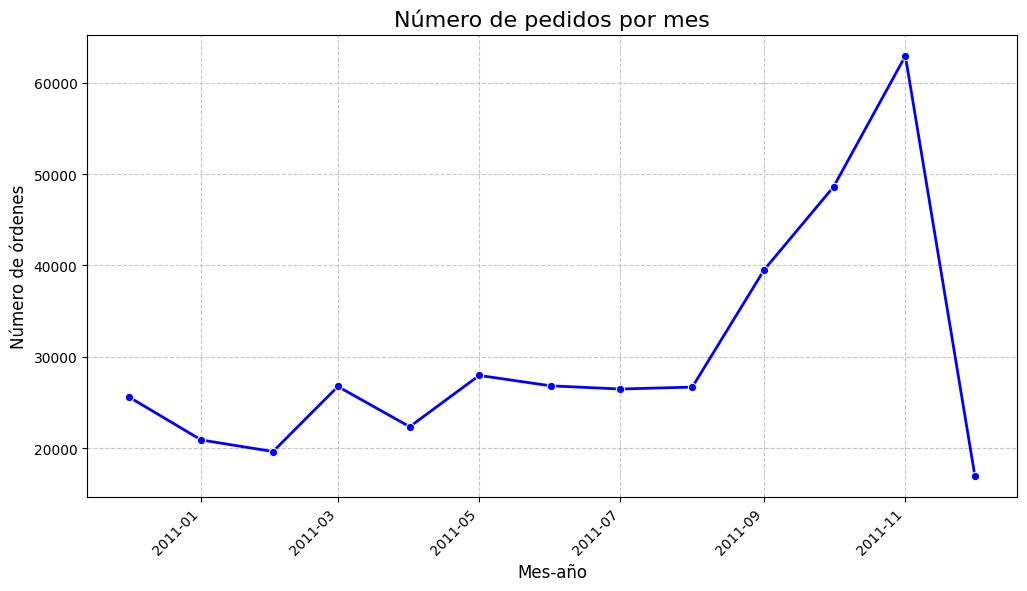

In [71]:
plt.figure(figsize=(12, 6))

ax = sns.lineplot(x="month_year", y="InvoiceNo", data=plot, marker='o', color='blue', linewidth=2)

ax.set_title('Número de pedidos por mes', fontsize=16)
ax.set_xlabel('Mes-año', fontsize=12)
ax.set_ylabel('Número de órdenes', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

plt.xticks(rotation=45, ha='right')

**Análisis del Volumen de Compras a lo Largo del Año:**

* **Tendencia Estacional:**
    * Se observa un incremento significativo en las compras durante el último trimestre del año.
    * Noviembre registra el mayor volumen de transacciones del año, siendo un pico que probablemente se debe a una fuerte influencia de la temporada navideña en el comportamiento del consumidor.
* **Estabilidad Relativa:**
    * A excepción del pico en noviembre y el aumento en el último trimestre, el volumen de compras se mantiene relativamente constante, indicando un patrón de consumo regular a lo largo del año, con una marcada variación estacional.

### ¿Cuántos pedidos hay al día?

<ipython-input-72-6fab1dc34570>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="WeekDay", y="InvoiceNo", data=plot2, palette=weekday_colors)


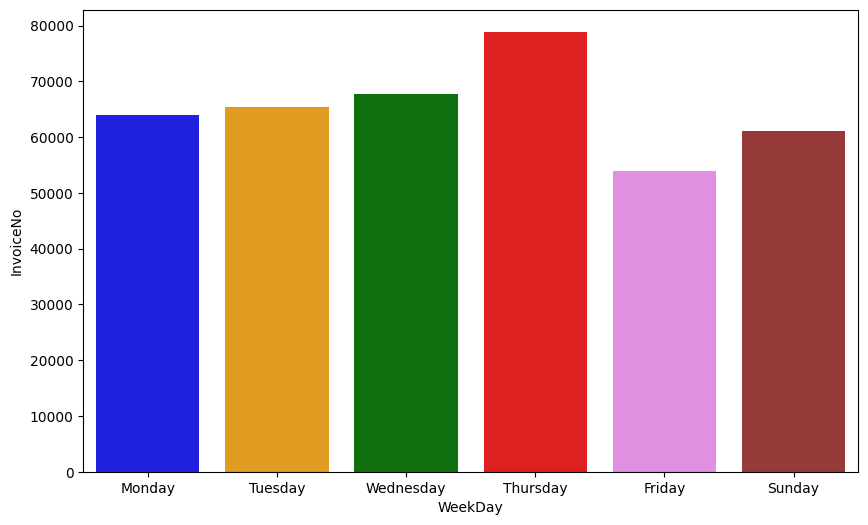

In [72]:
weekday_colors = ['blue', 'orange', 'green', 'red', 'violet', 'brown']

plt.figure(figsize=(10, 6))

ax = sns.barplot(x="WeekDay", y="InvoiceNo", data=plot2, palette=weekday_colors)

**Distribución General:**
- El gráfico muestra la cantidad de transacciones (InvoiceNo) para cada día de la semana.
- Se observa que el volumen de transacciones es relativamente constante a lo largo de la semana, con algunas variaciones.

**Ausencia de Transacciones el Sábado:**
- Un hallazgo notable es la ausencia total de transacciones registradas para el día sábado.
    * Esto podría deberse a:
        * Un error o filtro en el proceso de recopilación de datos.
        * Un cierre operativo del negocio o plataforma los sábados.
        * Un patrón de comportamiento del cliente que evita realizar compras ese dia.
    * Es necesario investigar más a fondo para determinar la causa exacta.

**Días de Mayor Actividad**
- Jueves presenta el mayor volumen de transacciones, seguido de miércoles y martes.
- Lunes, viernes y domingo tienen una cantidad menor en comparación a los dias de mitad de semana.

**Consistencia Relativa:**
- A pesar de las variaciones, el volumen de compras se mantiene en un rango relativamente similar durante la mayoría de los días de la semana.
- Esto sugiere que no hay una dependencia fuerte del día de la semana para la actividad de compras, con la excepción del sábado.

### ¿Cuántos pedidos por hora?

<ipython-input-73-62d4aa5c8c2a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="hour", y="InvoiceNo", data=plot3, palette="rocket")


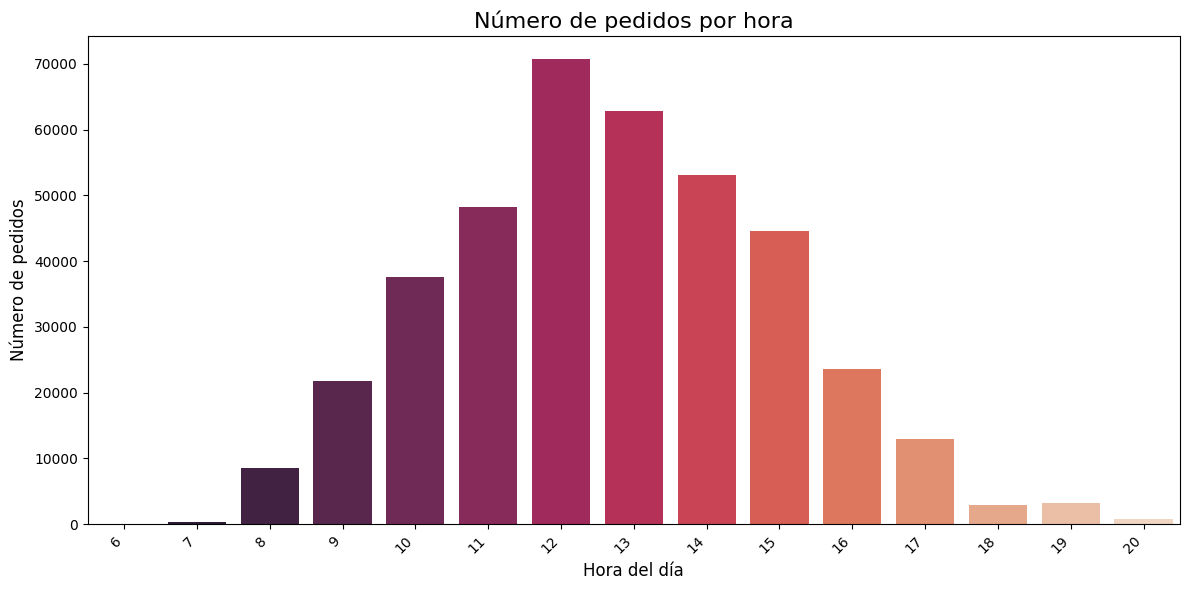

In [73]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(x="hour", y="InvoiceNo", data=plot3, palette="rocket")

ax.set_title('Número de pedidos por hora', fontsize=16)
ax.set_xlabel('Hora del día', fontsize=12)
ax.set_ylabel('Número de pedidos', fontsize=12)


plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

- Nos podemos dar cuenta que la mayor cantidad de transacciones se realiza entre las**12:00** y las **14:00**, y la gente suele comprar durante la hora del almuerzo.

- No hay transacciones después de las 20:00 y hasta las 6:00.

### ¿Qué mes genera mayores ingresos?

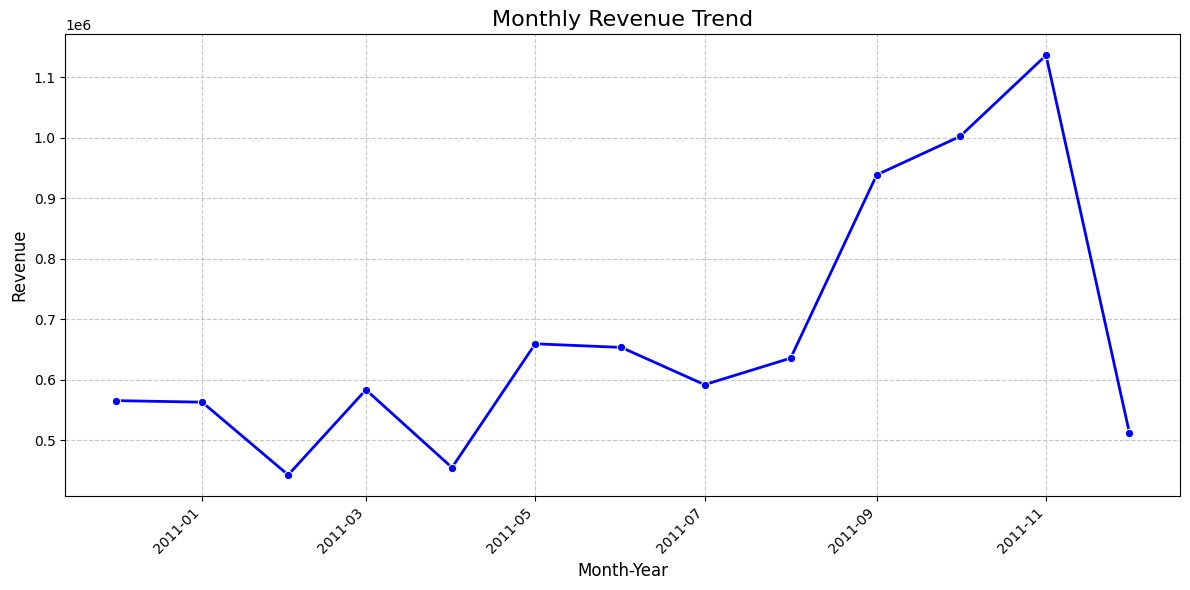

In [74]:
plt.figure(figsize=(12, 6))

ax = sns.lineplot(x='month_year', y='revenue', data=plot5, marker='o', color='blue', linewidth=2)

ax.set_title('Monthly Revenue Trend', fontsize=16)
ax.set_xlabel('Month-Year', fontsize=12)
ax.set_ylabel('Revenue', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Las mayores ventas también se dan durante el mes de **noviembre**, ya que el número de compras es el más alto.

### **3.3 Price**

A partir de las estadísticas descriptivas de la variable precio, observamos que la mayoría de los productos vendidos son bastante económicos. Probablemente, el comercio minorista vende artículos pequeños, como material de oficina, pequeñas decoraciones, etc.

In [75]:
pd.DataFrame(data['UnitPrice'].describe())

,UnitPrice
count,391150.000000
mean,2.874372
std,4.284738
min,0.040000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


Descripción de productos que cuestan más de 50 (Supuesto: misma moneda para ventas minoristas en diferentes países).

In [76]:
data[data['UnitPrice']>50]['Description'].unique().tolist()

['rustic  seventeen drawer sideboard',
 'vintage post office cabinet',
 'vintage red kitchen cabinet',
 'regency mirror with shutters',
 'love seat antique white metal',
 'vintage blue kitchen cabinet',
 'school desk and chair ',
 'chest natural wood 20 drawers',
 'decorative hanging shelving unit',
 'picnic basket wicker 60 pieces']

### Distribución de precios de bienes caros:

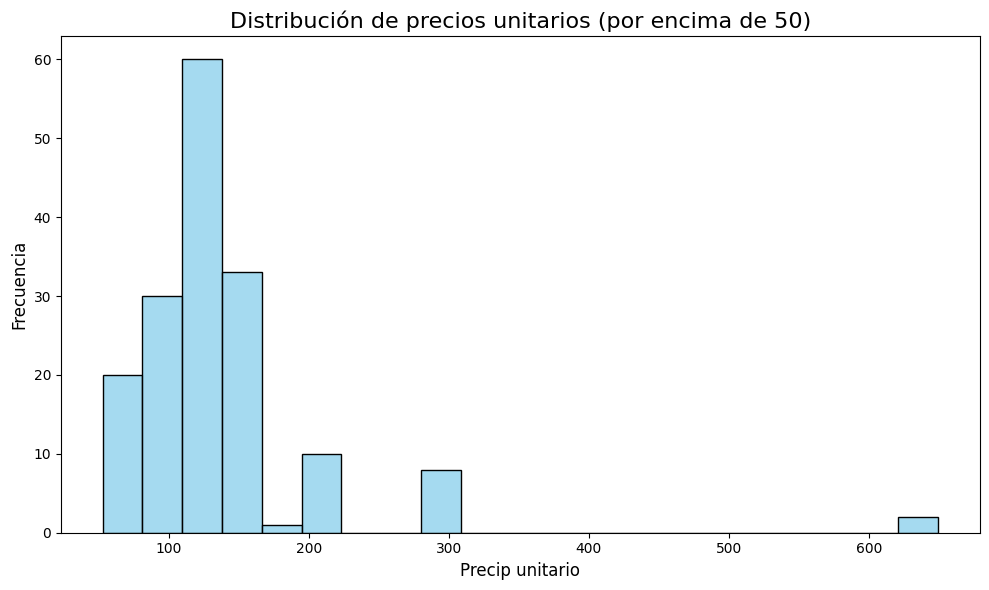

In [77]:
plt.figure(figsize=(10, 6))

ax = sns.histplot(data[data['UnitPrice'] > 50]['UnitPrice'], kde=False, color='skyblue')

ax.set_title('Distribución de precios unitarios (por encima de 50)', fontsize=16)
ax.set_xlabel('Precip unitario', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)

plt.tight_layout()
plt.show()

### **3.3 Transacciones por país**

Los clientes más exclusivos provienen del Reino Unido, por lo que es mejor centrarse en este país para la segmentación de clientes.

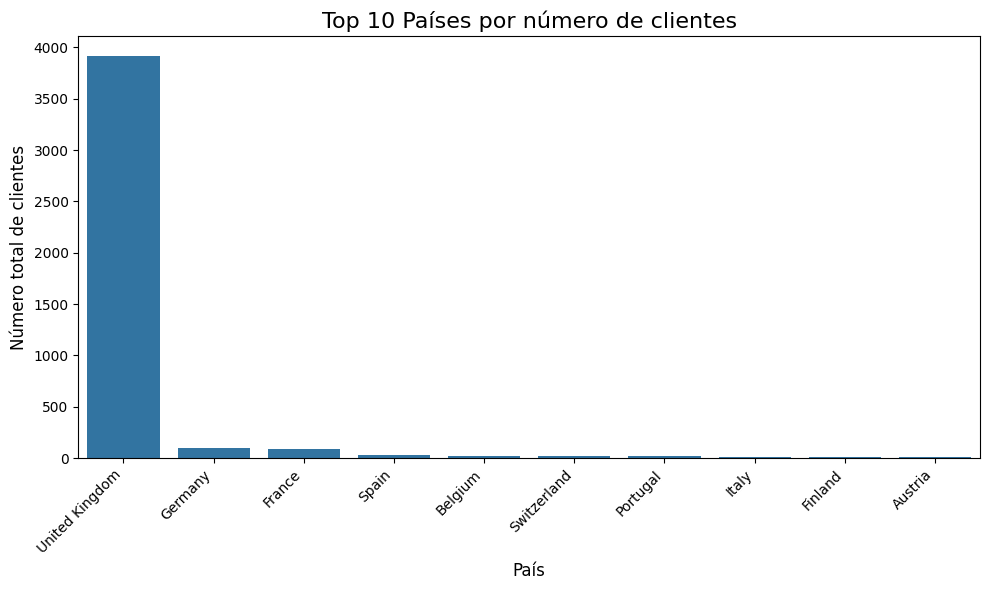

In [78]:
customer_country=data[['Country','CustomerID']].drop_duplicates()
customer_counts = customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Country', y='CustomerID', data=customer_counts.head(10))

ax.set_title('Top 10 Países por número de clientes', fontsize=16)
ax.set_xlabel('País', fontsize=12)
ax.set_ylabel('Número total de clientes', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

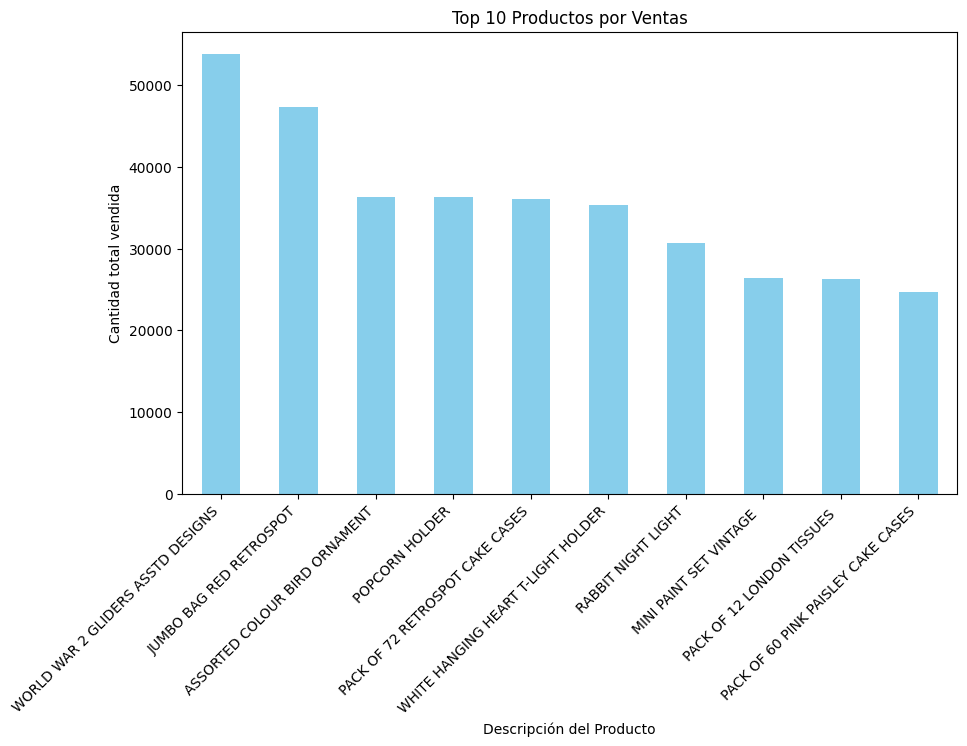

In [79]:
## Top 10 Products by Sales
product_sales = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
product_sales.plot(kind='bar', color='skyblue')
plt.title('Top 10 Productos por Ventas')
plt.xlabel('Descripción del Producto')
plt.ylabel('Cantidad total vendida')
plt.xticks(rotation=45, ha='right')
plt.show()

In [80]:
print("Las transacciones se realizaron en", len(data['Country'].unique().tolist()), "diferentes países")
print("Número de transacciones en las que no se especifica el país:", len(data[data['Country']=='Unspecified']))

Las transacciones se realizaron en 37 diferentes países
Número de transacciones en las que no se especifica el país: 241


In [81]:
plot6 = pd.DataFrame(data.groupby(['Country'])['revenue'].sum()).reset_index()
plot6 = plot6.sort_values(['revenue']).reset_index(drop=True)
plot7 = pd.DataFrame(data.groupby(['Country'])['revenue'].count()).reset_index()
plot7 = plot7.sort_values(['revenue']).reset_index(drop=True)

### La mayor cantidad de ventas se realiza en **Reino Unido**

<ipython-input-82-a279f7aca62f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Country', y='revenue', data=plot6.tail(10), estimator=max, ax=ax, palette="viridis")
<ipython-input-82-a279f7aca62f>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)


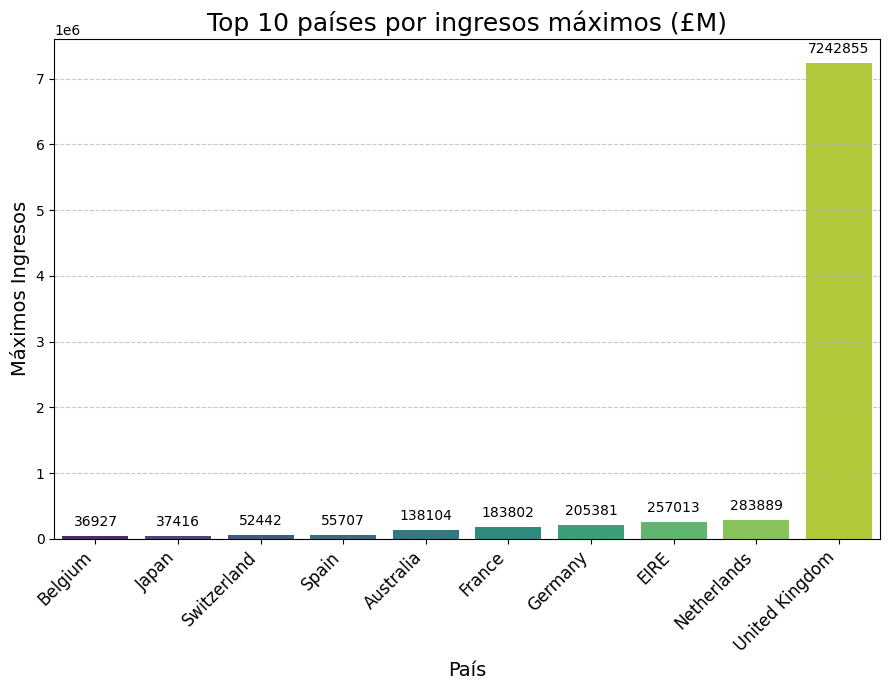

In [82]:
fig, ax = plt.subplots(figsize=(9, 7))

ax = sns.barplot(x='Country', y='revenue', data=plot6.tail(10), estimator=max, ax=ax, palette="viridis")

ax.set_title('Top 10 países por ingresos máximos (£M)', fontsize=18)
ax.set_xlabel('País', fontsize=14)
ax.set_ylabel('Máximos Ingresos', fontsize=14)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)

ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

### **Países por número de pedidos:**

El mayor número de pedidos se realizan en Reino Unido, lo cual es previsible, ya que la tienda tiene su sede en ese país.

<ipython-input-83-c19691baea2d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Country', y='revenue', data=plot7.tail(10), estimator=max, ax=ax, palette="rocket")
<ipython-input-83-c19691baea2d>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)


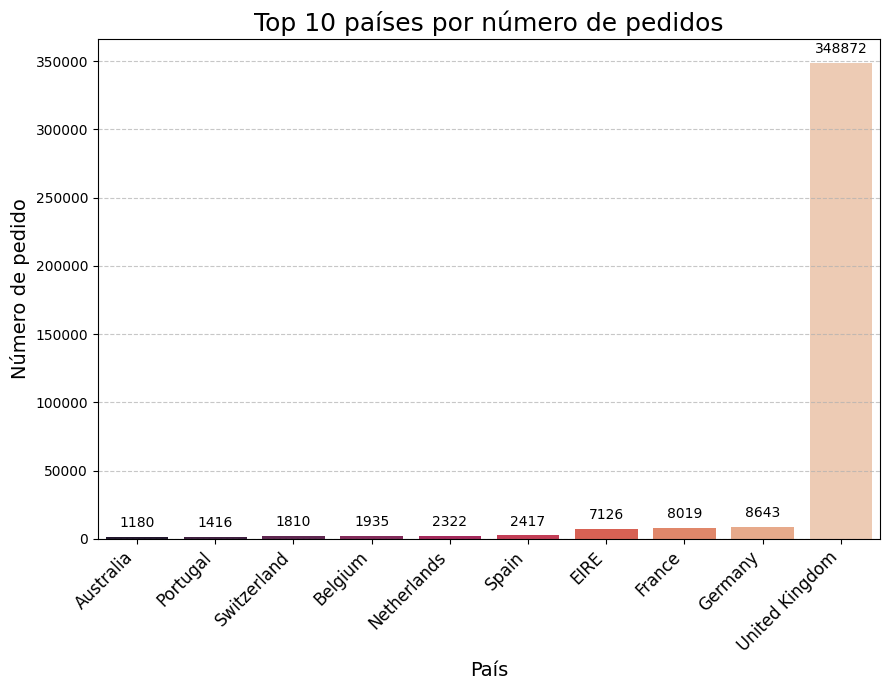

In [83]:
fig, ax = plt.subplots(figsize=(9, 7))

ax = sns.barplot(x='Country', y='revenue', data=plot7.tail(10), estimator=max, ax=ax, palette="rocket")

ax.set_title('Top 10 países por número de pedidos', fontsize=18)
ax.set_xlabel('País', fontsize=14)
ax.set_ylabel('Número de pedido', fontsize=14)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)

ax.grid(axis='y', linestyle='--', alpha=0.7)


for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

### **3.4 Top Customers**

Calculamos con qué frecuencia realizó una compra un cliente en particular durante el año:

In [84]:
data['freq'] = data.groupby('CustomerID')['CustomerID'].transform('count')
customer  = pd.DataFrame(data.groupby(['CustomerID'])['revenue'].sum().sort_values(ascending=False)).reset_index().head(10)
customer['CustomerID'].tolist()

[14646.0,
 18102.0,
 17450.0,
 16446.0,
 14911.0,
 12415.0,
 14156.0,
 17511.0,
 12346.0,
 16029.0]

Países donde residen los principales clientes

In [85]:
top_customer = data[data['CustomerID'].isin(customer['CustomerID'].tolist())][['CustomerID', 'Country', 'revenue', 'Quantity', 'freq']]
top_customer['Country'].unique().tolist()


['United Kingdom', 'EIRE', 'Netherlands', 'Australia']

## **4. Hipótesis**

Como mencionamos en un principio, la mayoría de registros de transacciones de los clientes se encuentran en Reino Unido, representando el 91,4 % de estos, nos enfocaremos en abarcar las hipótesis solo para **clientes del Reino Unido:**

### **Hipótesis 1: Agrupación de Clientes mediante K-Means (Método de Centroides)**

**Objetivo de la Hipótesis 1:**

En esta sección, nos enfocamos en segmentar a los clientes del mercado del Reino Unido utilizando el análisis RFM y el algoritmo K-Means. Se calcularán las métricas RFM (Recency, Frequency, MonetaryValue y AvgBasketValue) a partir del comportamiento de compra y se utilizarán métodos de validación (método del codo e índice de silueta) para determinar el número óptimo de clusters.

**Nota:** Se han realizado previamente las etapas de EDA y preprocesamiento, donde se filtró el dataset para el Reino Unido y se realizaron las transformaciones básicas (conversión de fechas, manejo de valores faltantes, etc.).

#### **Cálculo de la actualidad (Recency), la frecuencia (Frequency), los valores monetarios (Monetary Value) y el Valor promedio de la canasta (AvgBasketValue):**

-   **Actualidad (R)** como días desde la última compra: ¿Cuántos días hace de su última compra? Reste la fecha de compra más reciente de hoy para calcular el valor de actualidad. ¿Hace 1 día? ¿Hace 14 días? ¿Hace 500 días?

-   **Frecuencia (F)** como número total de transacciones: ¿Cuántas veces ha comprado el cliente en nuestra tienda? Por ejemplo, si alguien realizó 10 pedidos en un período de tiempo, su frecuencia es 10.

-   **Monetario (M)** como dinero total gastado: ¿Cuánto $$ (o la moneda que utilice para calcular) ha gastado este cliente? Nuevamente, limite el gasto a los últimos dos años o tome todo el tiempo. Simplemente sume el dinero de todas las transacciones para obtener el valor M.

-   **AvgBasketValue**: Valor promedio por transacción (Monetary Value dividido por Frequency).

Fuente: <https://www.putler.com/rfm-analysis/>

In [86]:
df_uk = data[data['Country'] == 'United Kingdom'].copy()
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,WeekDay,month_year,hour,revenue,freq
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,15.30,297
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,20.34,297
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,22.00,297
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,20.34,297
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,20.34,297


In [87]:
print(df_uk['InvoiceDate'].min())
print(df_uk['InvoiceDate'].max())

2010-12-01 08:26:00
2011-12-09 12:49:00


In [88]:
# Convertir CustomerID a entero
df_uk['CustomerID'] = df_uk['CustomerID'].astype(int)

In [89]:
# Asegurarse de que InvoiceDate está en formato datetime
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'], errors='coerce')

In [90]:
# Definir la fecha de referencia para calcular Recency (usamos la fecha máxima del dataset + 1 día)
reference_date = df_uk['InvoiceDate'].max() + pd.Timedelta(days=1)

In [91]:
# Calcular Recency: número de días desde la última compra
df_uk['Recency'] = (reference_date - df_uk['InvoiceDate']).dt.days

In [92]:
# Crear la variable TotalAmount: TotalAmount = Quantity * UnitPrice
df_uk['TotalAmount'] = df_uk['Quantity'] * df_uk['UnitPrice']

In [93]:
# Agrupar por CustomerID para calcular las métricas RFM:
# - Recency: Mínimo (el menor número de días, es decir, la última compra)
# - Frequency: Número de facturas únicas (InvoiceNo)
# - MonetaryValue: Suma total de TotalAmount
rfm = df_uk.groupby('CustomerID').agg({
    'Recency': 'min',
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

In [94]:
# Renombrar columnas para mayor claridad
rfm.rename(columns={'InvoiceNo': 'Frequency', 'TotalAmount': 'MonetaryValue'}, inplace=True)

# Calcular AvgBasketValue: Valor promedio por transacción (MonetaryValue / Frequency)
rfm['AvgBasketValue'] = rfm['MonetaryValue'] / rfm['Frequency']

# (Opcional) Tratar outliers: Si MonetaryValue está sesgado, se puede aplicar una transformación logarítmica
rfm['MonetaryValue_log'] = np.log1p(rfm['MonetaryValue'])

In [95]:
print("Métricas RFM para el mercado del Reino Unido (primeros 5 registros):")
rfm.head()

Métricas RFM para el mercado del Reino Unido (primeros 5 registros):


,CustomerID,Recency,Frequency,MonetaryValue,AvgBasketValue,MonetaryValue_log
0,12346,326,1,77183.60,77183.600000,11.253955
1,12747,2,11,4196.01,381.455455,8.342128
2,12748,1,206,31650.78,153.644563,10.362550
3,12749,4,5,4040.88,808.176000,8.304465
4,12820,3,4,942.34,235.585000,6.849427


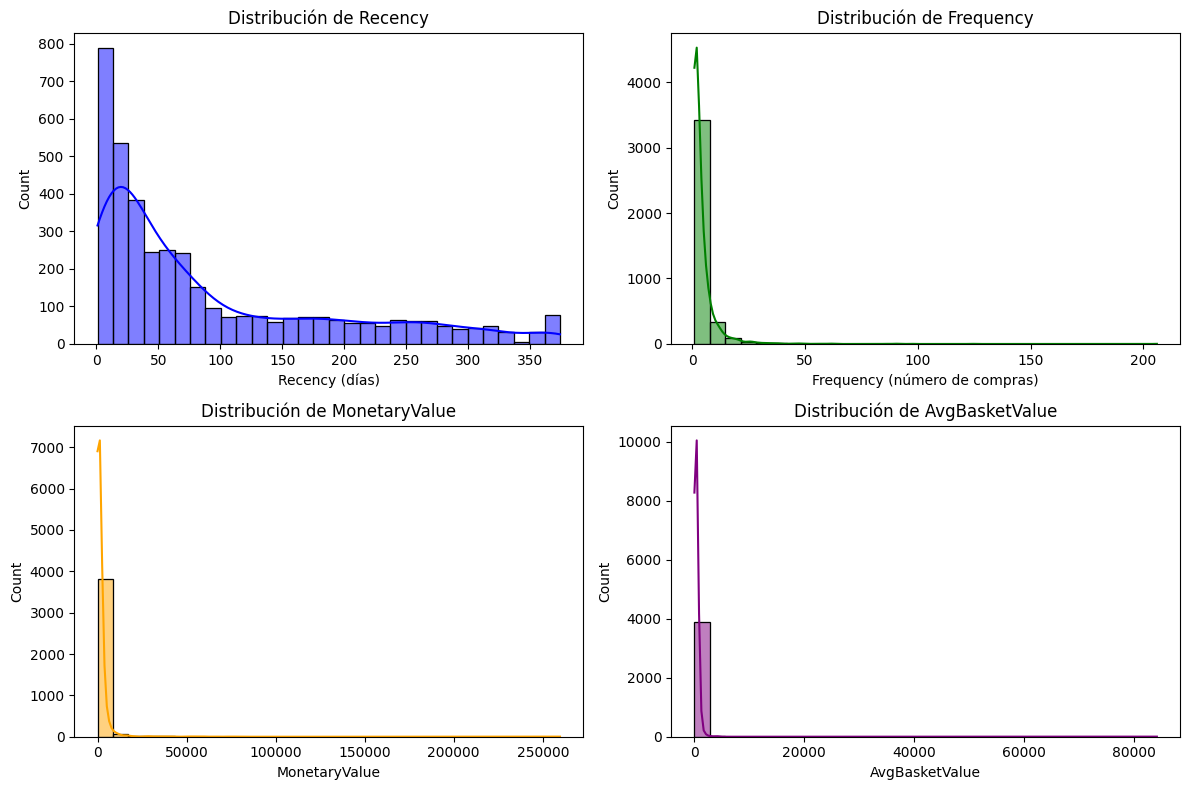

In [96]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.histplot(rfm['Recency'], bins=30, kde=True, color='blue')
plt.title('Distribución de Recency')
plt.xlabel('Recency (días)')

plt.subplot(2,2,2)
sns.histplot(rfm['Frequency'], bins=30, kde=True, color='green')
plt.title('Distribución de Frequency')
plt.xlabel('Frequency (número de compras)')

plt.subplot(2,2,3)
sns.histplot(rfm['MonetaryValue'], bins=30, kde=True, color='orange')
plt.title('Distribución de MonetaryValue')
plt.xlabel('MonetaryValue')

plt.subplot(2,2,4)
sns.histplot(rfm['AvgBasketValue'], bins=30, kde=True, color='purple')
plt.title('Distribución de AvgBasketValue')
plt.xlabel('AvgBasketValue')

plt.tight_layout()
plt.show()


## Aplicación de K-Means para Segmentación

Aplicaremos el algoritmo K-Means para segmentar a los clientes basándonos en las métricas RFM calculadas. Se escalarán las variables para asegurar que cada métrica contribuya de manera equilibrada.

Se utilizarán el método del codo y el índice de silueta para determinar el número óptimo de clusters (K). Esto ayudará a identificar la cantidad de segmentos que mejor capturan las diferencias en el comportamiento de compra de los clientes.

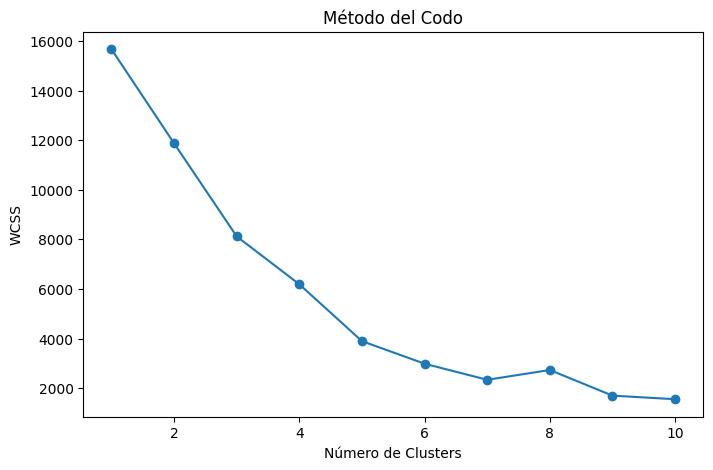

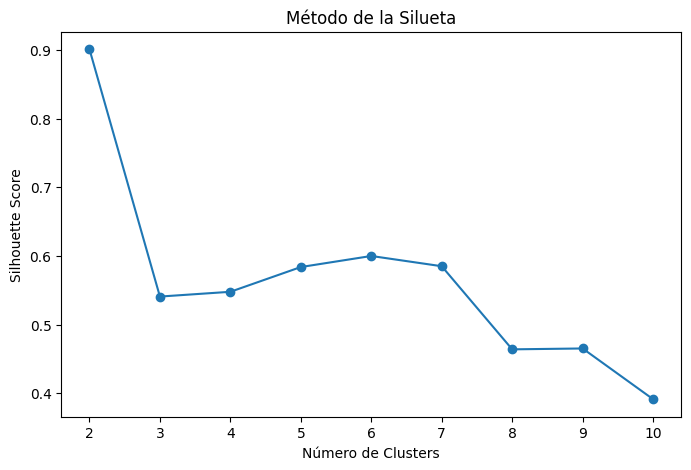

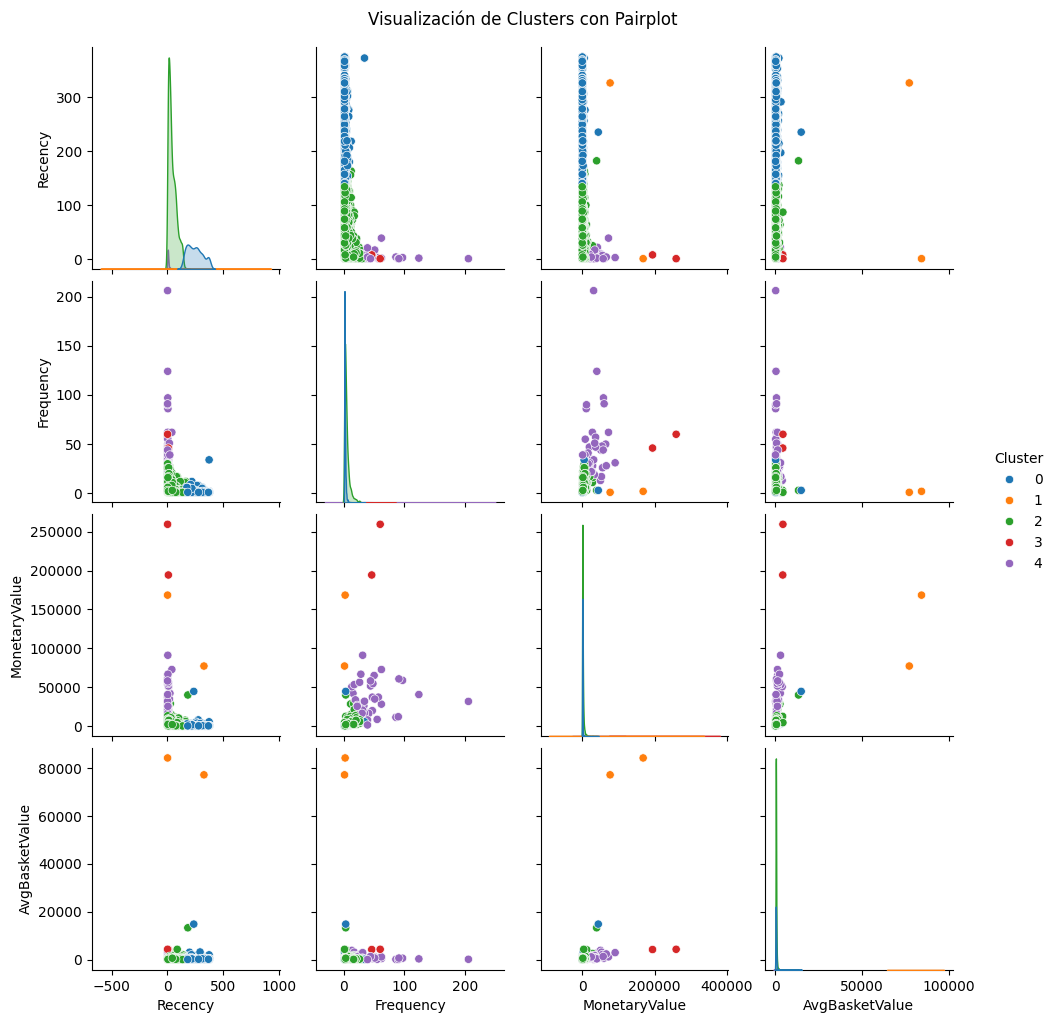

In [97]:
# --- Seleccionar variables RFM para el clustering ---
features = ['Recency', 'Frequency', 'MonetaryValue', 'AvgBasketValue']
X = rfm[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Determinar el número óptimo de clusters usando el método del codo ---
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

# --- Silhouette Analysis ---
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Método de la Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# --- Aplicar K-Means con el número óptimo de clusters ---
optimal_clusters = 5
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm['Cluster'] = kmeans_final.fit_predict(X_scaled)

# --- Visualización de los clusters usando pairplot ---
# Seleccionar las columnas a visualizar junto con la asignación de cluster
rfm_visual = rfm[['Recency', 'Frequency', 'MonetaryValue', 'AvgBasketValue', 'Cluster']]

# Definir una paleta de colores distintiva
palette = sns.color_palette("tab10", n_colors=optimal_clusters)

# Visualizar los clusters usando pairplot
sns.pairplot(rfm_visual, hue='Cluster', diag_kind='kde', palette=palette)
plt.suptitle('Visualización de Clusters con Pairplot', y=1.02)
plt.show()


#### Análisis de Resultados de Clustering

A continuación, se presenta un resumen de los resultados obtenidos a partir de las tres gráficas (Método del Codo, Método de la Silueta y Visualización de Clusters con Pairplot). Se compara, además, con la versión log-transformada (RFM Cluster Visualization (Log-Transformed)) para explicar cómo la transformación logarítmica puede mejorar la claridad de la segmentación.

---

### 1. Método del Codo (Elbow Method)

**Gráfico Observado**  
El gráfico del Método del Codo ilustra la relación entre el número de clusters (eje X) y la suma de cuadrados intra-cluster (WCSS, eje Y). El objetivo es identificar el punto donde la disminución de WCSS deja de ser significativa, lo cual sugiere un equilibrio entre la complejidad del modelo y la representatividad de los grupos.

**Interpretación**  
- Se observa una caída marcada de WCSS al pasar de 1 a 4 clusters, lo que indica que hasta 4 grupos explican una porción considerable de la varianza.  
- A partir de 4 o 5 clusters, la curva se aplana, sugiriendo que añadir más grupos no conlleva mejoras sustanciales en la reducción de la varianza intra-cluster.  
- Este comportamiento sugiere que **4 o 5 clusters** podrían ser adecuados, aunque la elección final debe complementarse con otras métricas, como el índice de silueta.

**Conclusión Elbow**  
El “codo” de la curva se ubica alrededor de **K=4 o K=5**. Esto nos orienta a verificar con otros indicadores (por ejemplo, la silueta) para confirmar el número óptimo de clusters.

---

### 2. Método de la Silueta (Silhouette Method)

**Gráfico Observado**  
El gráfico del índice de silueta (Silhouette Score) muestra cómo varía la calidad de la separación de los clusters conforme se incrementa su número.

**Interpretación**  
- Para K=2, se obtiene un índice de silueta muy elevado (~0.9), lo que indica una clara separación, pero puede ser excesivamente simplista al dividir la población en solo dos segmentos.  
- Para K=3 y K=4, el índice de silueta desciende, aunque permanece en un rango moderado (~0.5 a 0.6), indicando que la separación entre clusters es razonable.  
- A partir de K=8 o K=9, el índice de silueta cae de forma significativa (~0.4 o menos), lo que sugiere que un número muy alto de clusters puede fragmentar demasiado la población y empeorar la cohesión interna.

**Conclusión Silhouette**  
Tanto **K=4** como **K=5** muestran valores de silueta aceptables. Combinando esta información con el Método del Codo, se determina que 4 o 5 clusters son opciones razonables. Por lo general, **K=4** ofrece un buen equilibrio entre interpretabilidad y cohesión de los grupos.

---

### 3. Visualización de Clusters con Pairplot

**Gráfico Observado**  
El pairplot representa la distribución de las variables (Recency, Frequency, MonetaryValue y AvgBasketValue) en la diagonal, y en las celdas restantes se muestran diagramas de dispersión, coloreados según el cluster asignado.

**Interpretación**  
- **Recency:** La mayoría de los clientes presenta valores bajos (indican compras recientes), pero existen grupos con Recency alta (falta de actividad).  
- **Frequency:** Algunos clusters agrupan a clientes con frecuencia de compra muy baja, mientras que otros muestran frecuencia moderada o alta.  
- **MonetaryValue:** Se observa una gran dispersión; ciertos clientes alcanzan valores monetarios muy elevados (posibles “big spenders”).  
- **AvgBasketValue:** Permite identificar si el gasto elevado se concentra en pocas compras grandes o muchas compras pequeñas.

**Conclusión Pairplot**  
La dispersión en *MonetaryValue* y *Frequency* sugiere que una transformación logarítmica puede ayudar a mejorar la definición y la visualización de los grupos, al reducir la influencia de outliers extremos.


#### **Aplicando Transformación Logarítmica**

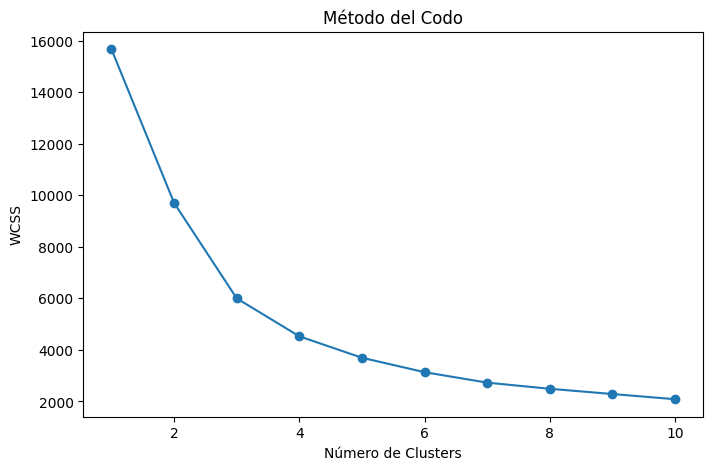

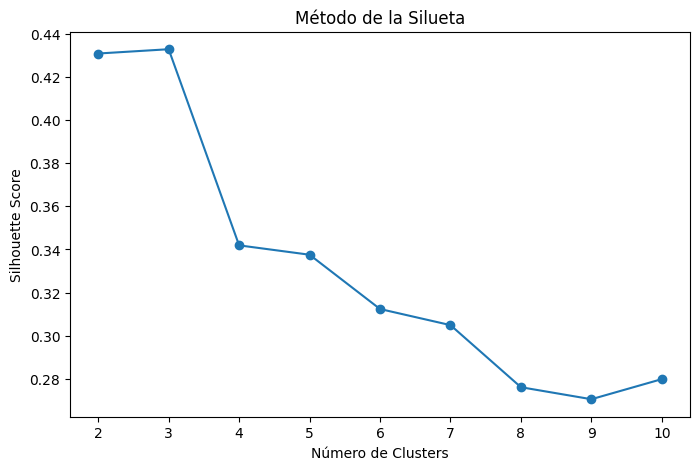

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.11/dist-packages/seabo

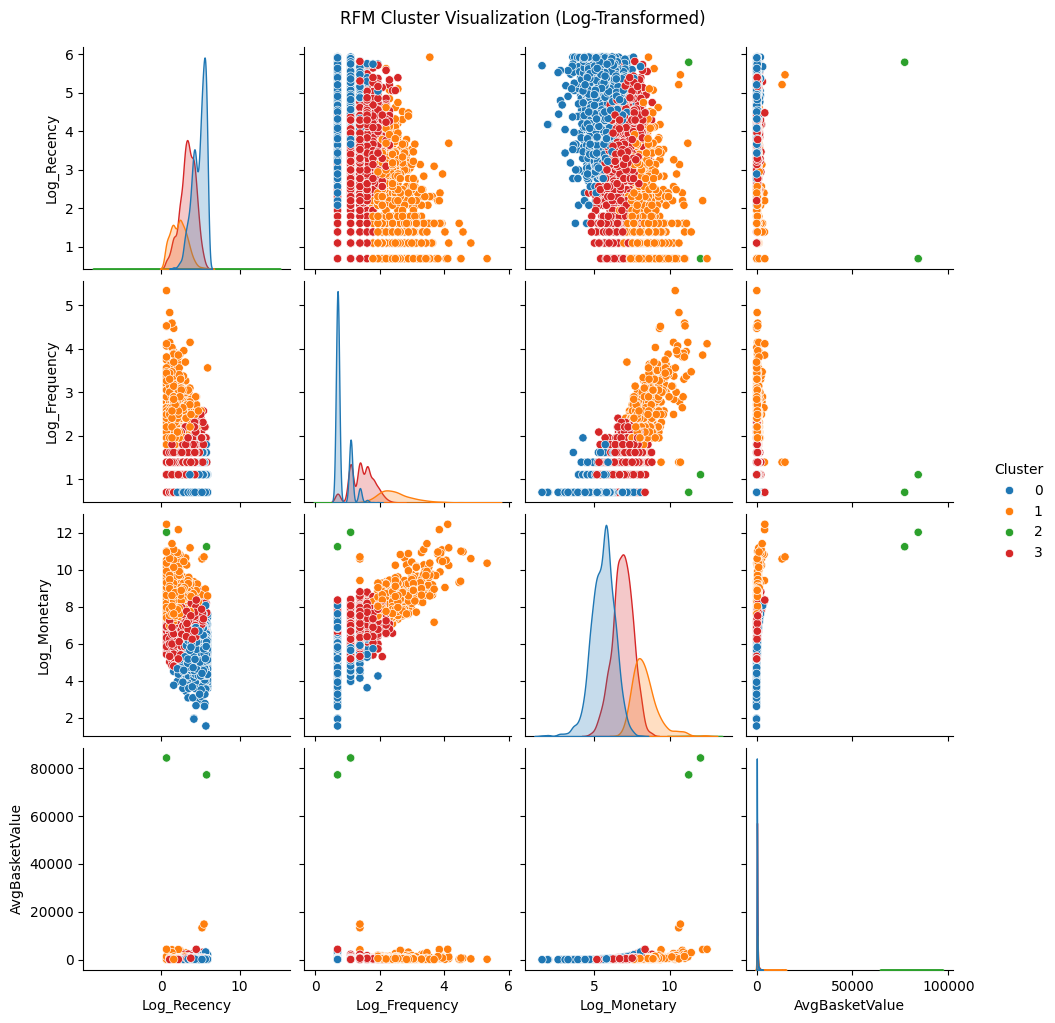

In [100]:
# -------------------------------------------------------------------
# 1. Aplicar la transformación logarítmica a Recency, Frequency y MonetaryValue
# -------------------------------------------------------------------
# Evitar valores negativos o cero aplicando np.log1p (log(1 + x))
rfm['Log_Recency'] = np.log1p(rfm['Recency'])
rfm['Log_Frequency'] = np.log1p(rfm['Frequency'])
rfm['Log_Monetary'] = np.log1p(rfm['MonetaryValue'])

# -------------------------------------------------------------------
# 2. Seleccionar las columnas transformadas para el clustering
# -------------------------------------------------------------------
features_log = ['Log_Recency', 'Log_Frequency', 'Log_Monetary', 'AvgBasketValue']
X_log = rfm[features_log]

# -------------------------------------------------------------------
# 3. Escalar las variables
# -------------------------------------------------------------------
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

# -------------------------------------------------------------------
# 4. Determinar el número óptimo de clusters (método del codo)
# -------------------------------------------------------------------
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_log_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

# -------------------------------------------------------------------
# 5. Análisis de la Silueta
# -------------------------------------------------------------------
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(X_log_scaled)
    silhouette_avg = silhouette_score(X_log_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Método de la Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# -------------------------------------------------------------------
# 6. Aplicar K-Means con el número óptimo de clusters (por ejemplo, K=5)
# -------------------------------------------------------------------
optimal_clusters = 5
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm['Cluster'] = kmeans_final.fit_predict(X_log_scaled)

# -------------------------------------------------------------------
# 7. Visualización con Pairplot (versión log-transformada)
# -------------------------------------------------------------------
rfm_log_visual = rfm[['Log_Recency', 'Log_Frequency', 'Log_Monetary', 'AvgBasketValue', 'Cluster']]

sns.pairplot(rfm_log_visual, hue='Cluster', diag_kind='kde', palette=palette)
plt.suptitle('RFM Cluster Visualization (Log-Transformed)', y=1.02)
plt.show()


#### Análisis de Resultados tras la Transformación Logarítmica

Después de aplicar la transformación logarítmica a las métricas **Recency**, **Frequency** y **MonetaryValue**, se han obtenido los siguientes resultados en los gráficos de *Elbow Method*, *Silhouette Method* y *RFM Cluster Visualization (Log-Transformed)*.

---

### 1. Método del Codo (K-Means con Log-Transformación)

**Observaciones Principales:**
- La curva de WCSS desciende rápidamente hasta alrededor de 4 o 5 clusters, tras lo cual la pendiente se estabiliza.
- El efecto de la transformación logarítmica en las variables RFM no altera sustancialmente la forma del codo, pero sí puede mejorar la calidad de la segmentación al reducir la influencia de valores extremadamente altos.

**Conclusión:**
- **K=4** o **K=5** siguen siendo candidatos adecuados, por lo que se recomienda combinar este resultado con el índice de silueta y la interpretabilidad de los clusters para la elección final.

---

### 2. Método de la Silueta (Silhouette Method)

**Observaciones Principales:**
- Tras la transformación logarítmica, se aprecia una ligera variación en los valores del índice de silueta, aunque la tendencia general se mantiene.
- K=2 muestra un valor de silueta muy alto, pero es demasiado simplista para la mayoría de los escenarios de segmentación.
- K=4 o K=5 presentan valores de silueta razonables (~0.3-0.4 en este caso), que, aunque no sean muy altos, resultan aceptables considerando la complejidad de los datos.

**Conclusión:**
- Al igual que con el método del codo, **K=4** o **K=5** continúan siendo opciones plausibles. La silueta confirma que un número mayor de clusters (por ejemplo, 7, 8 o 9) empeora la cohesión interna de los grupos.

---

### 3. Visualización de Clusters (Log-Transformada)

**Pairplot de Variables Log-Transformadas:**
- **Log_Recency, Log_Frequency, Log_Monetary**: Al comprimir los valores altos, la distribución de las variables se hace más compacta, revelando con mayor claridad la separación entre los clusters.
- **AvgBasketValue (sin transformar)**: Mantener esta variable sin transformación permite identificar clientes con altos valores de cesta media, aunque podría considerarse también su log-transform si los valores son muy dispersos.




##**Evaluación de los Resultados**

In [120]:

# Silhouette Score (mayor es mejor)
silhouette_avg = silhouette_score(X_log_scaled, rfm['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Davies-Bouldin Index (menor es mejor)
db_index = davies_bouldin_score(X_log_scaled, rfm['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.4f}")


#--------------------------------------------------------------------------
# Validación Cruzada
def evaluate_clustering_stability(X, n_clusters, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    ari_scores = []

    # Realizar clustering en el conjunto completo para referencia
    kmeans_ref = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels_ref = kmeans_ref.fit_predict(X)

    for train_idx, test_idx in kf.split(X):
        # Entrenar en el conjunto de entrenamiento
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        kmeans.fit(X[train_idx])

        # Predecir en el conjunto de prueba
        labels_test = kmeans.predict(X[test_idx])

        # Comparar con las etiquetas de referencia para esos índices
        ari = adjusted_rand_score(labels_ref[test_idx], labels_test)
        ari_scores.append(ari)

    return np.mean(ari_scores), np.std(ari_scores)

# Evaluar estabilidad
stability_mean, stability_std = evaluate_clustering_stability(
    X_log_scaled,
    n_clusters=optimal_clusters
)

print(f"\nEstabilidad del clustering (ARI):")
print(f"Media: {stability_mean:.4f}, Desviación Estándar: {stability_std:.4f}")


Silhouette Score: 0.3316
Davies-Bouldin Index: 1.3007

Estabilidad del clustering (ARI):
Media: 0.8562, Desviación Estándar: 0.1330


###**Silhouette Score:**

Mide qué tan similar es un objeto a su propio cluster (cohesión) en comparación con otros clusters (separación). Varía entre -1 y 1.

Para cada punto, se calcula:

a = distancia media entre el punto y todos los demás puntos en el mismo cluster
b = distancia media entre el punto y todos los puntos del cluster más cercano


El valor de Silhouette para el punto es: (b - a) / max(a, b)
El Silhouette Score final es el promedio de todos los puntos

**Interpretación de los valores:**

1: Los objetos están muy bien agrupados
0: Los objetos están en la frontera entre dos clusters
-1: Los objetos probablemente están en el cluster equivocado


0.3316 está en el rango positivo, lo que indica una calidad de clustering moderada. No es un valor extremadamente alto, pero es aceptable para muchas aplicaciones prácticas


###**Davies-Bouldin Index**

El índice DB mide el promedio de "similitud" entre cada cluster y el cluster más similar a él. La "similitud" se define como la suma de las dispersiones dentro de dos clusters dividida por la distancia entre sus centroides


Para cada cluster i, se calcula el ratio máximo de la suma de dispersiones internas de i y j dividido por la distancia entre sus centroides
El índice DB es el promedio de estos ratios máximos


**Rango e interpretación:**

Valores más bajos indican mejor clustering
El rango comienza en 0 (no hay límite superior fijo, pero típicamente está entre 0 y 2-3)
Un valor de 0 sería ideal (clusters perfectamente separados)

Un valor de 1.3007 moderado-bajo indica una calidad de clustering razonablemente buena donde los clusters están moderadamente bien separados entre sí.

**Consideraciones prácticas:**

En segmentación de clientes, valores por debajo de 1.5 suelen considerarse aceptables.




###**Validación Cruzada del Modelo**

La validación cruzada para estabilidad del clustering es un enfoque que evalúa qué tan consistente y robusta es la segmentación cuando los datos cambian ligeramente. Como el clustering es un método no supervisado (sin etiquetas), no se puede validar de la misma forma que en modelos supervisados, pero hay estrategias para medir su estabilidad.

Para este modelo, se crea un clustering de referencia usando TODOS los datos que será la "base de comparación" la cual divide los datos en 5 partes iguales ("folds"). En cada iteración, el modelo usa 4 partes para entrenar y 1 para test, Compara cómo clasifica el modelo entrenado con 80% de datos vs el modelo de referencia.

Finalmente, mide la similitud entre dos asignaciones de clusters donde el Rango: -1 (total desacuerdo) a 1 (clusters idénticos) y 0 = asignaciones aleatorias

####**La media de 0.8562:**

  Indica que el modelo produce resultados muy consistentes cuando se aplica a diferentes subconjuntos de datos y sugiere que los patrones identificados son robustos y no aleatorios.


####**La desviación estándar de 0.1330:**

  Es relativamente baja, lo que refuerza la estabilidad del modelo e indica que la variabilidad entre diferentes ejecuciones es limitada.


  El modelo K-means con 5 clusters es altamente estable y los segmentos identificados representan patrones reales en los datos.
  Hay una alta confiabilidad en que estos segmentos son estructuralmente significativos.

  Estos segmentos se mantendrán estables con nuevos datos
  Las estrategias de marketing basadas en estos segmentos tienen una base sólida

###**Características de los Clusters**

In [109]:

# Calcular estadísticas descriptivas por cluster
cluster_stats = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'count'],
    'Frequency': ['mean', 'median', 'sum'],
    'MonetaryValue': ['mean', 'median', 'sum'],
    'AvgBasketValue': ['mean', 'median']
}).round(2)

print("Estadísticas por cluster:")
print(cluster_stats)

# Calcular el porcentaje de clientes en cada cluster
cluster_sizes = rfm['Cluster'].value_counts(normalize=True).mul(100).round(1)
print("\nDistribución de clientes por cluster (%):")
print(cluster_sizes)

Estadísticas por cluster:
        Recency              Frequency               MonetaryValue             \
           mean median count      mean median    sum          mean     median   
Cluster                                                                         
0         37.54   20.0  1607      7.37    5.0  11849       2753.02    1706.57   
1        163.50  163.5     2      1.50    1.5      3     122828.05  122828.05   
2         82.47   52.5   124      7.29    2.0    904      13729.41    3236.69   
3        208.50  208.5     2      3.00    3.0      6      42225.40   42225.40   
4        133.13   94.0  2181      1.75    1.0   3817        360.48     316.25   

                    AvgBasketValue            
                sum           mean    median  
Cluster                                       
0        4424095.89         408.42    369.15  
1         245656.10       80709.92  80709.92  
2        1702447.24        1593.31   1301.35  
3          84450.80       14075.13  14075.1

##**Interpretación de los Clusters:**

- **Cluster 0 (Azul) (41.0% de los clientes)**: Suele agrupar clientes con valores log-transformados de Recency y Frequency relativamente bajos, y Monetary moderado.

    - Recencia: Baja (37.54 días media / 20 días mediana)

    - Frecuencia: Alta (7.37 compras en promedio)

    - Valor monetario: Moderado (2753.02 en promedio)

    - Valor de canasta: Moderado-alto (408.42 en promedio)

  **Perfil: "Clientes Activos Regulares" - Son fieles, compran regularmente, y han visitado la tienda recientemente**


- **Cluster 1 (Naranja) (0.1% de los clientes)**: Muestra un rango amplio en Recency (alta inactividad para algunos) y una dispersión notable en Frequency y Monetary. Indica un grupo heterogéneo donde algunos clientes pueden estar inactivos y otros haber tenido compras aisladas pero de alto monto.

  - Recencia: Alta (163.50 días) - Hace tiempo que no compran
  - Frecuencia: Muy baja (1.5 compras)
  - Valor monetario: Extremadamente alto (122828.05)
  - Valor de canasta: Extraordinariamente alto (80709.92)

  **Perfil: "Mega Compradores Inactivos" - Son solo 2 clientes que realizaron compras de valor extremadamente alto pero no han vuelto. Pueden ser clientes corporativos o mayoristas. También podría tratarse de datos que se deban validar.**

- **Cluster 2 (Verde) (3.2% de los clientes)**: Presenta clientes con un comportamiento variado en Recency y Frequency, aunque suelen tener un gasto menor que el cluster 3 (Rojo), lo que sugiere un perfil de cliente con actividad moderada.

  - Recencia: Moderada (82.47 días en promedio)
  - Frecuencia: Moderada-alta (7.29 compras)
  - Valor monetario: Alto (13729.41 en promedio)
  - Valor de canasta: Muy alto (1593.31 en promedio)

  **Perfil: "Grandes Compradores" - Aunque compran con frecuencia similar al Cluster 0, gastan mucho más por compra. Son un pequeño segmento de clientes de alto valor.**

- **Cluster 3 (Rojo) (0.1% de los clientes)**: Se caracteriza por un gasto elevado (Log_Monetary alto) y, en algunos casos, frecuencia moderada. Son clientes de alto valor que conviene retener.

  - Recencia: Muy alta (208.50 días) - Hace mucho que no compran
  - Frecuencia: Baja (3 compras)
  - Valor monetario: Muy alto (42225.40)
  - Valor de canasta: Muy alto (14075.13)

  Perfil: "Grandes Compradores Perdidos" - También son solo 2 clientes, con alto valor de compra pero que no han regresado en mucho tiempo.

- **Cluster 4 (Morado) (55.7% de los clientes)**: Reúne clientes con valores consistentemente bajos en las variables log-transformadas, lo que indica poca actividad reciente, baja frecuencia y menor gasto.

  - Recencia: 133.13 días (media) / 94 días (mediana) desde última compra
  - Frecuencia: Muy baja (1.75 compras en promedio, mediana de 1)
  - Valor monetario: Extremadamente bajo (360.48 en promedio)
  - Valor de canasta: Bajo (224.53 en promedio)

  **Perfil: "Clientes Ocasionales/Inactivos" - Representan la mayoría de la base de clientes. Han comprado poco, gastan poco por compra, y llevan bastante tiempo sin volver. Son clientes que probablemente hicieron una compra de prueba pero no se convirtieron en habituales.**

**Ventajas de la Transformación Logarítmica:**
1. **Reducción de la Influencia de Outliers**: La compresión de valores extremos en Frequency y Monetary permite una mejor diferenciación de los grupos, evitando que unos pocos clientes de gasto muy alto dominen el análisis.
2. **Claridad de la Segmentación**: Las fronteras entre clusters se observan con mayor nitidez, lo que facilita la interpretación de cada segmento.
3. **Interpretabilidad Consistente**: Aunque se deba tener presente que los ejes representan valores log-transformados, la comparación relativa entre clientes se vuelve más manejable.

---

### Observaciones Finales

- **Selección de K**: Tanto el método del codo como la silueta sugieren que **K=4** o **K=5** ofrecen un balance razonable entre complejidad y coherencia de los clusters.
- **Transformación Logarítmica**: Mejora la cohesión interna de los grupos y la visibilidad de la segmentación, en especial para las variables Monetary y Frequency.

Con esta transformación logarítmica y el correspondiente análisis, se logra una segmentación más clara y estable, brindando la posibilidad de definir estrategias específicas para cada tipo de cliente dentro del mercado del Reino Unido.

### **Recomendaciones estratégicas:**

Esta segmentación muestra una estructura típica en retail: una gran base de clientes ocasionales, un núcleo de clientes regulares, y un pequeño grupo de grandes compradores. Los clusters 1 y 3 parecen contener valores atípicos (outliers) que podrían requerir una estrategia especial o incluso ser analizados separadamente. Con base en los datos se podrían generar estrategias para cada cluster, un ejemplo de esto pod´ria ser:

- Para Cluster 4 (55.7%): Implementar campañas de reactivación con ofertas atractivas para incentivar una segunda compra. Muchos pueden ser clientes de una sola compra que necesitan un motivo para volver.

- Para Cluster 0 (41%): Desarrollar programas de fidelización para mantener su actividad. Son los clientes más valiosos por su recencia y frecuencia. Recompensar su lealtad.

- Para Cluster 2 (3.2%): Realizar seguimiento personalizado, son VIPs que gastan mucho. Podrían beneficiarse de un servicio premium o atención especial.

- Para Clusters 1 y 3 (0.2% combinado): Investigar individualmente estos 4 clientes de altísimo valor. Por su comportamiento inusual, podrían ser clientes corporativos o casos especiales.



## Conclusiones

Tras aplicar **K-Means** a los datos del conjunto *Online Retail* (centrándonos en el mercado del Reino Unido y utilizando las métricas RFM), se pueden extraer las siguientes conclusiones:

---

Hipótesis 1: K-Means
- **Ventajas:**  
  - **Eficiencia y Escalabilidad:** K-Means maneja adecuadamente grandes volúmenes de datos, siendo relativamente rápido en su ejecución.  
  - **Definición Clara de Perfiles:** Al elegir un número de clusters (por ejemplo, 4 o 5), se logra una segmentación equilibrada, lo que facilita la interpretación de cada grupo (clientes de alto valor, inactivos, etc.).  
- **Desafíos:**  
  - **Forma de los Clusters:** K-Means asume clusters de forma esférica, lo cual puede no ajustarse bien a datos con distribuciones irregulares.  
  - **Elección de K:** Requiere predefinir el número de clusters, usualmente apoyándose en métodos como el codo o el índice de silueta.  
- **Conclusión K-Means:**  
  Proporciona una segmentación práctica y fácil de interpretar, especialmente cuando se elige un número de clusters acorde a los objetivos de negocio. La aplicación de transformaciones logarítmicas en las variables RFM puede mejorar la cohesión de los grupos.


 **K-Means** se destaca por su **eficiencia** y por facilitar la interpretación de los resultados, siempre que se defina cuidadosamente el número de clusters.

 La evaluación del modelo con los Davies-Bouldin Index y Silhouette Score mostró una calidad de clustering moderada, que pudo verse afectada por outliers, lo que es común de este tiepo de modelo.

  Existe cierta superposición entre los clusters (no están perfectamente separados) y la estructura de segmentación captura patrones reales, aunque hay algunas áreas donde los clusters no están tan bien definidos